# **Why Short Availability Data Matters in Your Backtests!**  

This notebook explores how short availability constraints affect backtests in stocks and crypto, revealing key takeaways:  

<div style="background-color:#f8f9fa; border-left: 5px solid #0077b6; padding:10px;">

### **Stocks:**  
- A selected basket of stocks with historical short availability issues significantly underperformed SPY in the out-of-sample period, despite a bull market
- Ignoring short availability constraints in backtests that include short positions can overstate profitability  
- Despite limited availability history, we can still factor it into backtests for the period we have. If we note that performance drops when short availability constraints are introduced but remains strong when ignored, the strategy is likely to fail live. 
- Ideas for capturing alpha from short signals even when no stock is available to borrow.

### **Crypto:**  
The crypto examples reveal similar impacts of short availability constraints, mirroring findings in stocks.  

</div>


## Background  

We uncovered some intriguing short signals in historical data and built models that, based on our backtests, looked like they would print money. Excited by the results, after factoring in all fees and spreads, we rolled them out live and eagerly tried to execute—only to be hit with the same frustrating error message: "No Stock to Borrow!"

Our predictions were right, but we simply couldn’t get the trades executed. That experience made one thing painfully clear: historical short availability data wasn’t just a minor detail—it was a critical ingredient for making realistic backtests.  

No problem, we thought. We’d just buy the historical data from data providers. But after endless searching and countless meetings, we realized no one had what we needed—intraday short availability data for all U.S. stocks. Later, we hit the same roadblock with crypto.  

And so, our journey began: if the data didn’t exist, we’d record it ourselves.*

### **Curating Our Own Short Availability Datasets**  

We now maintain two historical datasets:  

1. **U.S. Stock Short Availability, Short Fees, Short Rebates (via Interactive Brokers – a prime US broker)**
- Coverage: All U.S. stocks (survivorship bias-free)
- Data since: August 2023 (to present)
- Frequency: Every 15 minutes (incl. pre and post market)
- Quality: +95% uptime (some minor gaps due to downtime)
- Source: Interactive Brokers (data is publicly available real-time, we have historically recorded it)
2. **Crypto Short Availability (via Binance)**
- Coverage: All USDT-denominated cryptocurrencies (survivorship bias-free)
- Data since: June 2024 (to present)
- Frequency: Every 5 minutes (24h/day)
- Quality: +95% uptime (some minor gaps due to downtime)
- Source: Binance (data is publicly available real-time, we have historically recorded it)

## **Scope**

The purpose of this notebook is to run through some examples that demonstrate the value of incorporating historical short availability data into systematic strategies for stocks and crypto in two key areas:  

- Making backtests that include short positions more realistic  
- Identifying potential alpha opportunities 

#### **Note:**

The examples below focus solely on the isolated impact of incorporating short availability data into research. They are NOT intended as robust backtests (therefore ignore other costs and constraints) but rather as inspiration to illustrate how ignoring short availability in your research may lead to overly optimistic results or missed opportunities.  

Nothing in this notebook constitutes investment or trading advice.


## **Examples**

In [1]:
import pandas as pd 
import numpy as np 

---
### **1. Stocks**

In [2]:
# Settings 
BENCHMARK_TICKER = "SPY"
TRADING_DAYS_PER_YEAR = 252
BARS_PER_DAY = 78  # 6.5 hours * 60 min / 5 min bars
ANNUAL_PERIODS = TRADING_DAYS_PER_YEAR * BARS_PER_DAY
MA_LOOKBACK_PERIOD = 100  # Lookback for signal moving average
SIGNAL_THRESHOLD = 0.03  # Signal threshold as a fraction
MIN_SHARES_AVAILABLE = 1_000  # Minimum number of shares required for a short position
RTH_OPEN = "09:30" # regular trading hours open time
RTH_CLOSE = "16:00" # "" close time
OOS_START = "2023-11-02" # out of sample start date

#### **1.1 Importing the Data**

**Short availability**: Number of shares available to short, recorded at 15-minute intervals  

In [3]:
short_availability = pd.read_pickle("data/stock_data/shrt_available.pkl").between_time(RTH_OPEN, RTH_CLOSE)  
short_availability

,IONQ,EH,GME,SGML,ABR,MULN,SAVA,AI,MAXN,VFS
date,,,,,,,,,,
2023-08-21 09:30:03,3100000.0,150000.0,65000.0,300000.0,700000.0,0.0,75000.0,500000.0,700000.0,0.0
2023-08-21 09:45:03,3100000.0,150000.0,80000.0,300000.0,700000.0,0.0,75000.0,500000.0,700000.0,0.0
2023-08-21 10:00:04,3000000.0,150000.0,70000.0,300000.0,700000.0,0.0,75000.0,450000.0,700000.0,0.0
2023-08-21 10:15:04,3100000.0,150000.0,65000.0,300000.0,700000.0,0.0,200000.0,450000.0,650000.0,0.0
2023-08-21 10:30:04,3100000.0,150000.0,65000.0,300000.0,700000.0,0.0,200000.0,450000.0,650000.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2024-12-05 14:45:03,500000.0,600000.0,800000.0,100000.0,250000.0,0.0,150000.0,500000.0,150000.0,4000.0
2024-12-05 15:00:03,450000.0,600000.0,750000.0,100000.0,250000.0,0.0,200000.0,500000.0,150000.0,3000.0
2024-12-05 15:15:04,450000.0,600000.0,750000.0,100000.0,250000.0,0.0,200000.0,500000.0,150000.0,4000.0


**Short fees and rebates:** Follows the same structure as above (for potential use later).

In [4]:
short_fees = pd.read_pickle("data/stock_data/shrt_fees.pkl").between_time(RTH_OPEN, RTH_CLOSE)  
short_rebates = pd.read_pickle("data/stock_data/shrt_rebates.pkl").between_time(RTH_OPEN, RTH_CLOSE)  

**Forward-adjusted close prices:** 5min bars, forward adjusted for splits and dividends

In [5]:
fwd_adjusted_closes = pd.read_pickle("data/stock_data/fwdadjcloses.pkl").shift().dropna()
# Note: .shift() aligns the 5-min close price with the actual time of the short availability snapshots
fwd_adjusted_closes

,XPEV,IONQ,EH,GME,SGML,ABR,MULN,SAVA,AI,MAXN,VFS,SPY
date,,,,,,,,,,,,
2023-08-22 09:35:00,16.2800,15.0200,18.8700,219.337521,34.630,71.667915,2.488444e-05,4.098652,32.730,13.9300,19.2350,647.056166
2023-08-22 09:40:00,16.0200,14.5984,18.5000,216.485896,34.380,71.466660,2.510667e-05,4.130494,32.300,14.0700,20.9300,646.747974
2023-08-22 09:45:00,16.0200,14.7000,18.3233,214.941265,34.200,70.995521,2.387556e-05,4.138510,32.329,13.6900,21.6000,645.926129
2023-08-22 09:50:00,15.8300,14.5850,18.2500,214.347177,34.180,70.902777,2.444444e-05,4.105981,31.900,13.7100,21.2999,646.278349
2023-08-22 09:55:00,15.8289,14.4750,17.9000,211.852005,33.930,70.763661,2.426667e-05,4.079016,31.710,13.6000,20.9200,645.911454
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-10 15:35:00,13.0650,32.9000,15.5950,321.342539,12.365,78.110608,7.977778e-09,0.998673,40.850,0.0655,4.5401,893.924967
2024-12-10 15:40:00,13.1000,32.8800,15.5700,320.216147,12.370,78.056496,7.972000e-09,1.002105,40.560,0.0655,4.5400,893.806301
2024-12-10 15:45:00,13.1050,32.8899,15.5600,321.401948,12.420,77.840048,7.977778e-09,1.002105,41.280,0.0655,4.5452,894.132632


#### **1.2 Why These Stocks?**

Here's how we chose them: our database contains short availability data for all U.S. stocks, and we wanted to identify those with the most **"runs" of zero availability**. We did this in three steps:

- **Step 1:** Defined an in-sample period from 2023-08-21 to 2023-11-01.  
- **Step 2:** Counted the number of "zero-availability runs" for each stock.  
- **Step 3:** Sorted and selected the 10 stocks with the highest zero-run counts during this period.  

SPY was then added to the price data as a benchmark.

##### **Plotting & Analyzing Cumulative Returns**  

Let’s plot and analyze the key stats of the equally weighted cumulative returns for our selected 10-stock basket vs. SPY (benchmark) after 2023-11-01:


Risk-adjusted return (Basket): -0.46
Risk-adjusted return (Benchmark): 2.78
Beta: 1.2


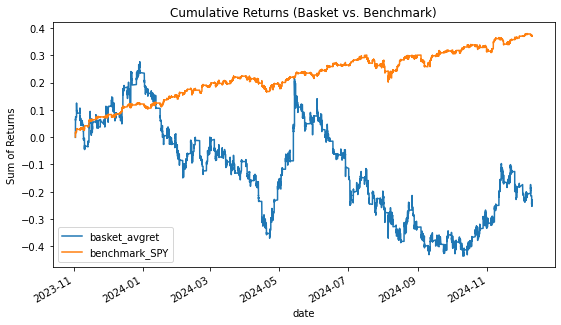

In [6]:
# Compute portfolio returns
comp_port = pd.DataFrame({
    'basket_avgret': fwd_adjusted_closes.pct_change()
        .drop(columns=BENCHMARK_TICKER).mean(axis=1),
    'benchmark_SPY': fwd_adjusted_closes[BENCHMARK_TICKER].pct_change()
})
# Cumulative sum plot
comp_port[OOS_START:].cumsum().plot(
    figsize=(9, 5), title="Cumulative Returns (Basket vs. Benchmark)",
    ylabel="Sum of Returns"
)
# Compute risk-adjusted returns and beta
basket_riskadj = round(
    comp_port.loc[OOS_START:, 'basket_avgret'].mean() /
    comp_port.loc[OOS_START:, 'basket_avgret'].std() * np.sqrt(ANNUAL_PERIODS), 2
)
benchmark_riskadj = round(
    comp_port.loc[OOS_START:, 'benchmark_SPY'].mean() /
    comp_port.loc[OOS_START:, 'benchmark_SPY'].std() * np.sqrt(ANNUAL_PERIODS), 2
)
beta = round(
    comp_port.loc[OOS_START:].cov()['basket_avgret']['benchmark_SPY'] /
    comp_port.loc[OOS_START:]['benchmark_SPY'].var(), 2
)
# Print results in a cleaner format
print(f"Risk-adjusted return (Basket): {basket_riskadj}")
print(f"Risk-adjusted return (Benchmark): {benchmark_riskadj}")
print(f"Beta: {beta}")

**Conclusion:** Interestingly, despite having a positive correlation to the benchmark (beta 1.2) the basket of stocks we chose with the prior history of lacking short availability significantly underperformed the benchmark, despite the bull market. 

#### **1.3 Merging Short Availability & Price Data: Handling Different Frequencies**  

Since higher-frequency data is generally more signal-rich, we align everything to 5-minute intervals by forward-filling the short availability data. This assumes that short availability is relatively stable over short periods.  

To test this assumption, we check the autocorrelation coefficient of raw availability data. If the coefficient is close to 1, it suggests that short availability is stable in the short-term, making forward-filling a reasonable method.  

As shown below, all selected stocks have an autocorrelation coefficient > 0.9, supporting this approach.

In [7]:
# 1 lag autocorrelations
short_availability.apply(lambda x: x.autocorr(lag=1))

IONQ    0.994948
EH      0.983826
GME     0.993639
SGML    0.993928
ABR     0.971154
MULN    0.982652
SAVA    0.961964
AI      0.973475
MAXN    0.994116
VFS     0.968952
dtype: float64

In [8]:
# processing: now lets align the data as described above
short_availability.index = short_availability.index.floor('T')
join_idx = pd.DataFrame(index=fwd_adjusted_closes.index)
short_availability = join_idx.join(short_availability).fillna(method='ffill')
fwd_returns = fwd_adjusted_closes.pct_change().shift(-1) # creating our forward returns i.e. the percentage change holding for t to t+1

#### **1.4 Limited Short Availability Impact on a Simple Short Strategy**

Let's create a simple very short momentum strategy and then compare the gross returns of the strategy to those including constraints for short availability. As the point of the example is only to highlight the impact of availability limitations, transaction costs are excluded. 

Risk-Adjusted Return (Excl. Availability Constraints): 1.62
Risk-Adjusted Return (Incl. Availability Constraints): 0.52


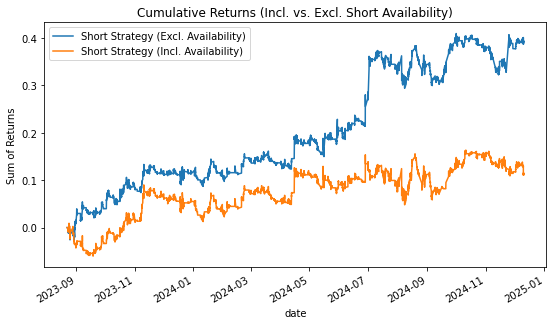

In [9]:
# Step 1: Generate Short Momentum Signal  
# Compute the moving average difference as a percentage  
ma_diff = (fwd_adjusted_closes - fwd_adjusted_closes.rolling(MA_LOOKBACK_PERIOD).mean()) / \
          fwd_adjusted_closes.rolling(MA_LOOKBACK_PERIOD).mean()
# Generate short signals (-1 for a short signal, 0 otherwise)  
short_signals = ma_diff.applymap(lambda x: -1 if x < -SIGNAL_THRESHOLD else 0)  
# Create a mask indicating where shorting is possible (1 if shares available, 0 otherwise)  
short_availability_mask = short_availability.applymap(lambda x: 1 if x > MIN_SHARES_AVAILABLE else 0)  

# Step 2: Compute Strategy Returns (Equal-Weighted)  
# Raw short strategy returns (ignoring availability constraints)  
short_returns_excl_availability = (short_signals * fwd_returns).mean(axis=1)  
# Short strategy returns with short availability constraints  
short_returns_incl_availability = (short_signals * short_availability_mask * fwd_returns).mean(axis=1)  

# Step 3: Plot Cumulative Returns  
pd.DataFrame({
    'Short Strategy (Excl. Availability)': short_returns_excl_availability.cumsum(),
    'Short Strategy (Incl. Availability)': short_returns_incl_availability.cumsum()
}).plot(figsize=(9, 5), title='Cumulative Returns (Incl. vs. Excl. Short Availability)',
        ylabel='Sum of Returns')

# Step 4: Compute & Print Risk-Adjusted Returns  
riskadj_excl_availability = round(
    (short_returns_excl_availability.mean() / short_returns_excl_availability.std()) * np.sqrt(ANNUAL_PERIODS), 2
)
riskadj_incl_availability = round(
    (short_returns_incl_availability.mean() / short_returns_incl_availability.std()) * np.sqrt(ANNUAL_PERIODS), 2
)
print(f"Risk-Adjusted Return (Excl. Availability Constraints): {riskadj_excl_availability}")
print(f"Risk-Adjusted Return (Incl. Availability Constraints): {riskadj_incl_availability}")

**Conclusion:** A significant portion of the strategy's performance came from the incorrect assumption that shorting was always possible at key moments—highlighting why factoring in short availability is essential in backtests involving short positions. If one were to then include realistic transaction costs, the true returns of this simple strategy would likely have been negative.

#### **1.5 How to Validate Backtests Despite Limited Availability History**  

While more data is always better, we can still extract meaningful insights even with limited short availability history. A simple approach is to split performance into two periods:  

1. **Pre-short availability data**: Assume naive returns, ignoring short availability constraints.  
2. **Post-short availability data**: Compare naive returns with strategy returns that account for short availability constraints.  

From this, we estimate the impact of short availability constraints on earlier periods.  

##### **Example:**  

Let's define $ T $ as the current time, $ T - N_1 $ as the start of our full backtest, and $ T - N_2 $ as the start of our short availability history, where $ N_1 > N_2 $.  

We can then define the return series as:  

$ r_{\text{excl, pre}} = \text{Strategy returns from } T - N_1 \text{ to } T - N_2 \text{ (excluding short availability constraints)} $

$ r_{\text{excl, post}} = \text{Strategy returns from } T - N_2 \text{ to } T \text{ (excluding short availability constraints)} $

$ r_{\text{incl, post}} = \text{Strategy returns from } T - N_2 \text{ to } T \text{ (including short availability constraints)} $


**Step 1: Estimate Constraint Impact**  
Calculate the performance drag caused by short constraints:

$ \Delta_{\text{post}} = r_{\text{excl, post}} - r_{\text{incl, post}} $

**Step 2: Adjust Returns pre $ T - N_2 $**  
Estimate the pre-availability returns by applying the observed performance impact:  

$ \hat{r}_{\text{incl, pre}} = r_{\text{excl, pre}} - \Delta_{\text{post}} $


**Step 3: Construct the Synthetic Return Series**  
Create a synthetic adjusted backtest returns (including estimated and actual short availbility constraint impact) for the full period by concatenating:  

$ r_{\text{incl, synth}} = [\hat{r}_{\text{incl, pre}}, r_{\text{incl, post}}] $


##### **Alternative Refinements**  
For a more sophisticated estimation of $ r_{\text{incl, synth}} $, we could:  
- Use alpha returns (market-neutral residuals) instead of raw returns, as this would remove the market component from the performance
- Model  $ \Delta_{\text{post}} $ as a function of factors like strategy turnover, volatility, etc.  


### **1.6 Extracting Alpha Despite Borrow Constraints**  

A natural question arises: if borrow constraints exist, how can one still extract alpha? In the case of stocks, two potential approaches come to mind:

1) **Using Multiple Brokers:**  
   While we can expect some correlation between prime broker availability constraints, it is possible that certain brokers may have shares available for borrowing when others do not. The practical challenge here is that, since we are currently collecting data only from Interactive Brokers, the viability of this approach is difficult to test historically.

2) **Market-Hedged, Long-Only Strategy:**  
   Consider a basic discrete short strategy where our signal $ S $ is defined as:

   $
   S =
   \begin{cases} 
   -1, & \text{if short} \\
   0, & \text{otherwise}
   \end{cases}
   $

   To circumvent borrow constraints, we can very simply transform this short strategy into a long-only strategy by shifting the signal upwards by 1:


   $
   S' =
   \begin{cases} 
   0, & \text{if short} \\
   1, & \text{otherwise}
   \end{cases}
   $

   We then hedge out the systematic market risk of this long-only approach using a low-cost ETF or futures contract. The gross return of the final hedged strategy would be:

   $
   R_{\text{strat,hedge}} = S' R_{\text{asset}} - B_{\text{market}} R_{\text{market}}
   $

   where $ B_{\text{market}} $ represents the market hedge ratio. This hedging approach could also be applied to a portfolio of such selected strategies. The feasibility of this approach would largely depend on whether the selected stocks exhibit excessive drag against the market benchmark (such as the 10 stocks selected above) or not.  


---
### **2. Crypto**

In [10]:
# Settings Crypto
BENCHMARK_TICKER_CRYPTO = "BTCUSDT"
TRADING_DAYS_PER_YEAR_CRYPTO = 365
BARS_PER_DAY_CRYPTO = 288  # 24 hours * 60 min / 5 min bars
ANNUAL_PERIODS_CRYPTO = TRADING_DAYS_PER_YEAR_CRYPTO * BARS_PER_DAY_CRYPTO
MA_LOOKBACK_PERIOD_CRYPTO = 100  # Lookback for signal moving average
SIGNAL_THRESHOLD_CRYPTO = 0.03  # Signal threshold as a fraction

#### **2.1 Importing the Data**

**Short availability for Binance Exchange**: Number of coins available to short, recording loop finishes at 5-minute intervals. Information is currently discrete where a value of 1 means that there is some short availability other values indicate no availabilty or missing information.

In [11]:
short_availability_binance = pd.read_pickle("data/crypto_data/short_availability_binance.pkl")['2024-06-17':]
short_availability_binance

,ACMUSDT,ALPINEUSDT,ASRUSDT,ATMUSDT,BARUSDT,JUVUSDT,LAZIOUSDT,MLNUSDT,OGUSDT,PORTOUSDT,SANTOSUSDT,CITYUSDT
date,,,,,,,,,,,,
2024-06-17 00:00:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0
2024-06-17 00:05:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0
2024-06-17 00:10:00,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0
2024-06-17 00:15:00,1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0
2024-06-17 00:20:00,1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-21 23:35:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0
2024-10-21 23:40:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0
2024-10-21 23:45:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0


**Close prices for Binance Exchange:** 5min close bars from Binance 

In [12]:
close_prices_binance = pd.read_pickle("data/crypto_data/close_prices_binance.pkl").shift().dropna()
# Note: again .shift() aligns the 5-min close price with the actual time of the short availability snapshots
close_prices_binance

ticker,ACMUSDT,ALPINEUSDT,ASRUSDT,ATMUSDT,BARUSDT,JUVUSDT,LAZIOUSDT,MLNUSDT,OGUSDT,PORTOUSDT,SANTOSUSDT,CITYUSDT,BTCUSDT
timestamp,,,,,,,,,,,,,
2024-06-17 00:05:00,2.032,1.611,2.845,2.847,2.242,2.081,1.917,19.50,3.960,2.041,4.453,2.590,66616.00
2024-06-17 00:10:00,2.028,1.611,2.842,2.843,2.236,2.075,1.915,19.45,3.941,2.036,4.447,2.589,66644.53
2024-06-17 00:15:00,2.030,1.611,2.842,2.832,2.232,2.075,1.915,19.45,3.948,2.038,4.448,2.588,66665.53
2024-06-17 00:20:00,2.027,1.609,2.839,2.830,2.231,2.076,1.911,19.41,3.936,2.035,4.442,2.582,66612.01
2024-06-17 00:25:00,2.020,1.607,2.841,2.829,2.227,2.067,1.910,19.39,3.940,2.032,4.413,2.581,66640.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-21 23:35:00,1.581,1.494,2.174,2.077,1.889,1.746,1.575,17.23,7.488,1.698,3.395,2.183,67494.04
2024-10-21 23:40:00,1.581,1.493,2.172,2.077,1.891,1.746,1.572,17.20,7.491,1.698,3.401,2.182,67479.50
2024-10-21 23:45:00,1.580,1.493,2.170,2.077,1.891,1.746,1.573,17.20,7.443,1.699,3.396,2.180,67523.99


#### **2.2 Why These Coins?**

As fan tokens are known for their price spike volatility, we selected listed fan tokens to analyse this basket and the impact of short availability.   

BTC was then added to the price data as a benchmark.

##### **Plotting & Analyzing Cumulative Returns**  

Plotting the equally weighted cumulative returns for the fan token basket vs. BTC (benchmark) for the period of the data:

Risk-adjusted return (Basket): 0.39
Risk-adjusted return (Benchmark): 0.33
Beta: 0.61


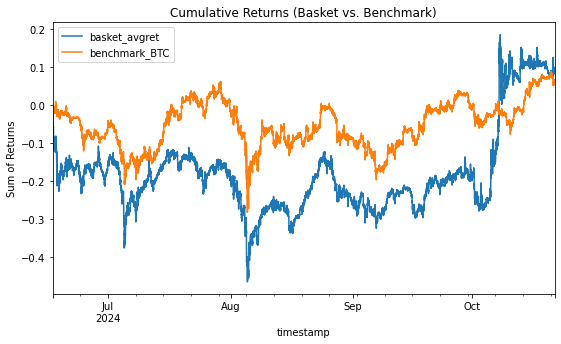

In [13]:
# Compute portfolio returns
comp_port_crypto = pd.DataFrame({
    'basket_avgret': close_prices_binance.pct_change()
        .drop(columns=BENCHMARK_TICKER_CRYPTO).mean(axis=1),
    'benchmark_BTC': close_prices_binance[BENCHMARK_TICKER_CRYPTO].pct_change()
})
# Cumulative sum plot
comp_port_crypto.cumsum().plot(
    figsize=(9, 5), title="Cumulative Returns (Basket vs. Benchmark)",
    ylabel="Sum of Returns"
)
# Compute risk-adjusted returns and beta
basket_riskadj = round(
    comp_port_crypto['basket_avgret'].mean() /
    comp_port_crypto['basket_avgret'].std() * np.sqrt(ANNUAL_PERIODS_CRYPTO), 2
)
benchmark_riskadj = round(
    comp_port_crypto['benchmark_BTC'].mean() /
    comp_port_crypto['benchmark_BTC'].std() * np.sqrt(ANNUAL_PERIODS_CRYPTO), 2
)
beta = round(
    comp_port_crypto.cov()['basket_avgret']['benchmark_BTC'] /
    comp_port_crypto['benchmark_BTC'].var(), 2
)
# Print results in a cleaner format
print(f"Risk-adjusted return (Basket): {basket_riskadj}")
print(f"Risk-adjusted return (Benchmark): {benchmark_riskadj}")
print(f"Beta: {beta}")

**Conclusion:** Unlike the stock basket the fan tockens seemed to produce similar gains to the Bitcoin benchmark during the selected period.

#### **2.3 Merging Short Availability & Price Data (Binance)**  

Since they are both on matching frequencies we just need to ensure that the indexing is the same on both, to do this we will use price as the bechmark index and join short availability to this, forward filling any missing values.

In [14]:
# processing: now lets align the data as described above
short_availability_binance.index = short_availability_binance.index.floor('T')
join_idx_binance = pd.DataFrame(index=close_prices_binance.index)
short_availability_binance = join_idx_binance.join(short_availability_binance).fillna(method='ffill')
fwd_returns_binance = close_prices_binance.pct_change().shift(-1) # creating our forward returns i.e. the percentage change holding for t to t+1

#### **2.4 Limited Short Availability Impact on a Simple Short Crypto Strategy**

As fan tokens are known for their short term price spikes we create a strategy to short when there has been a short term price rise. We then compare the gross returns of the strategy to those including constraints for short availability. Again, as the point of the example is only to highlight the impact of availability limitations, transaction costs are excluded. 

Risk-Adjusted Return (Excl. Availability Constraints): 3.99
Risk-Adjusted Return (Incl. Availability Constraints): 2.31


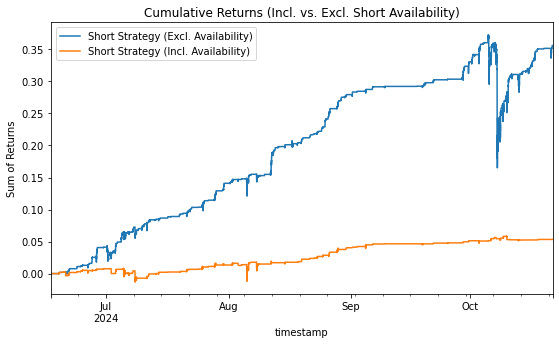

In [15]:
# Step 1: Generate Mean reversion Signal  
# Compute the moving average difference as a percentage  
ma_diff_binance = (close_prices_binance - close_prices_binance.rolling(MA_LOOKBACK_PERIOD_CRYPTO).mean()) / \
          close_prices_binance.rolling(MA_LOOKBACK_PERIOD_CRYPTO).mean()
# Generate short signals (-1 for a short signal, 0 otherwise)  
short_signals_binance = ma_diff_binance.applymap(lambda x: -1 if x > SIGNAL_THRESHOLD_CRYPTO else 0)  
# Create a mask indicating where shorting is possible (1 if shares available, 0 otherwise)  
short_availability_mask_binance = short_availability_binance.applymap(lambda x: 1 if x==1 else 0)  

# Step 2: Compute Strategy Returns (Equal-Weighted)  
# Raw short strategy returns (ignoring availability constraints)  
short_returns_excl_availability_binance = (short_signals_binance * fwd_returns_binance).mean(axis=1)  
# Short strategy returns with short availability constraints  
short_returns_incl_availability_binance = (short_signals_binance * short_availability_mask_binance * fwd_returns_binance).mean(axis=1)  

# Step 3: Plot Cumulative Returns  
pd.DataFrame({
    'Short Strategy (Excl. Availability)': short_returns_excl_availability_binance.cumsum(),
    'Short Strategy (Incl. Availability)': short_returns_incl_availability_binance.cumsum()
}).plot(figsize=(9, 5), title='Cumulative Returns (Incl. vs. Excl. Short Availability)',
        ylabel='Sum of Returns')

# Step 4: Compute & Print Risk-Adjusted Returns  
riskadj_excl_availability_binance = round(
    (short_returns_excl_availability_binance.mean() / short_returns_excl_availability_binance.std()) * np.sqrt(ANNUAL_PERIODS_CRYPTO), 2
)
riskadj_incl_availability_binance = round(
    (short_returns_incl_availability_binance.mean() / short_returns_incl_availability_binance.std()) * np.sqrt(ANNUAL_PERIODS_CRYPTO), 2
)
print(f"Risk-Adjusted Return (Excl. Availability Constraints): {riskadj_excl_availability_binance}")
print(f"Risk-Adjusted Return (Incl. Availability Constraints): {riskadj_incl_availability_binance}")

**Conclusion:** Again, a significant portion of the strategy's performance came from the incorrect assumption that shorting was always possible at key moments. A limitation of this particular study is that the data only indicates whether there was some availability, not how much. Due to the high turnover and transaction fees, it is likely that implementing such a strategy in live trading would be unprofitable.